Text(0.5, 1.0, 'UMAP projection of the Penguin dataset')

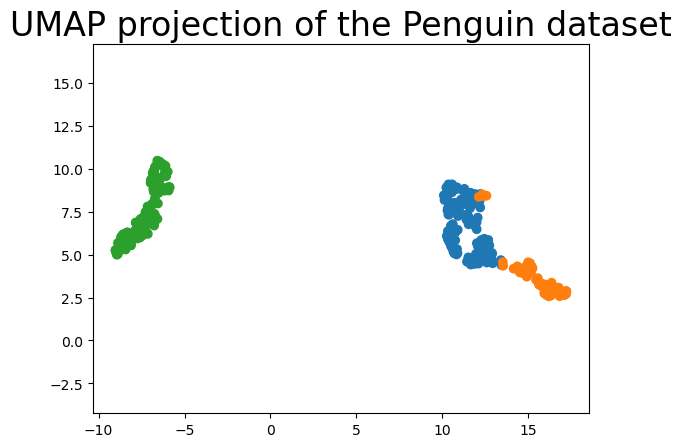

In [6]:
import umap 
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline

penguins = pd.read_csv("https://github.com/allisonhorst/palmerpenguins/raw/5b5891f01b52ae26ad8cb9755ec93672f49328a8/data/penguins_size.csv") 
penguins.head()

penguins = penguins.dropna() 
penguins.species_short.value_counts() 
reducer = umap.UMAP() 
penguin_data = penguins[ 
[ 
"culmen_length_mm", 
"culmen_depth_mm", 
"flipper_length_mm", 
"body_mass_g", 
] 
].values 
scaled_penguin_data = StandardScaler().fit_transform(penguin_data) 
embedding = reducer.fit_transform(scaled_penguin_data)

plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]) 
plt.gca().set_aspect('equal', 'datalim') 
plt.title('UMAP projection of the Penguin dataset', fontsize=24)